In [ ]:
import numpy as np
import pandas as pd
import open3d as o3d
import math
import os
from horizon import load, project, image, signal, camera, adjustment
# auto reload packages
%load_ext autoreload
%autoreload 2

# Azimuth estimation
## Load data

In [2]:
terrain_data = "../../data/terrain/geopose3k/"
cam_data = "../../data/geopose3k/"
horizon_data = "../../data/horizon/geopose3k/"

In [3]:
# cameras metadata
viewpoints = pd.read_csv(cam_data+'infos.csv')
viewpoints.head(3)

,id,latitude,longitude,elevation,yaw,pitch,roll,fov
0,28488116812_f5a57ca0f6_k,46.2173,10.16630,439.5,-0.272811,0.243122,0.014817,0.549165
1,28561570606,46.3463,6.84551,1407.0,-0.026613,0.087538,-0.013312,1.153100
2,eth_ch1_04032011388_01024,46.8600,9.83700,2246.5,-1.329290,-0.074533,0.025975,0.984675


In [4]:
# load elevation data
place_name = 'Alps_test'
if not os.path.exists(terrain_data+place_name+'.xyz'):
    raise Exception('Download elevation data first')
pc = o3d.io.read_point_cloud(terrain_data+place_name+'.xyz')

In [5]:
o3d.visualization.draw_geometries([pc])

## Load skyline

In [6]:
vpid = "eth_ch1_IMG_1820_01024"#"eth_ch1_1332166_01024"
vp = viewpoints[viewpoints['id']==vpid]
view_point = project.to_xy(vp['latitude'].item(), vp['longitude'].item(), vp['elevation'].item(), epsg='2056')

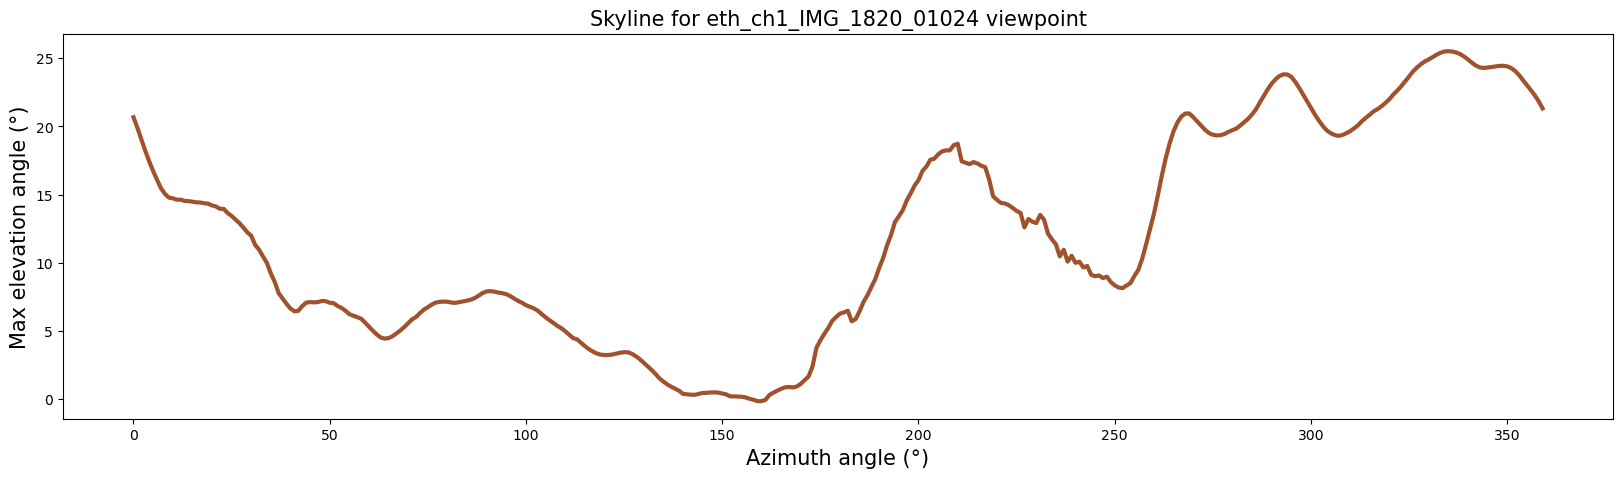

In [23]:
skyline = np.load(horizon_data+vpid+'.npy').astype(float)
depths = np.load(horizon_data+vpid+'_depth'+'.npy').astype(float)
smooth_skyline = signal.smooth_with_depth(skyline, depths)
signal.plot_skyline(smooth_skyline, f'Skyline for {vpid} viewpoint')
#signal.plot_skyline(skyline, f'Skyline for {vpid} viewpoint', depths=depths)

## Compare with image skyline

In [8]:
horizon_detector = image.HorizonDetector()
img_path = cam_data+vpid+'/'
try:
    horizon_detector.load_image(img_path+'photo.jpg')
except:
    print('no jpg found, trying jpeg')
    horizon_detector.load_image(img_path+'photo.jpeg')
horizon_detector.estimate_depth()
horizon_detector.extract_horizon()
horizon_detector.save_horizon(img_path, 'img_horizon')

In [10]:
# Some fov are not correct :(
fov = vp['fov'].item()
fov = round(math.degrees(fov))
fov

21

In [11]:
azimuth = vp['yaw'].item()
azimuth = round(math.degrees(azimuth))%360
azimuth

155

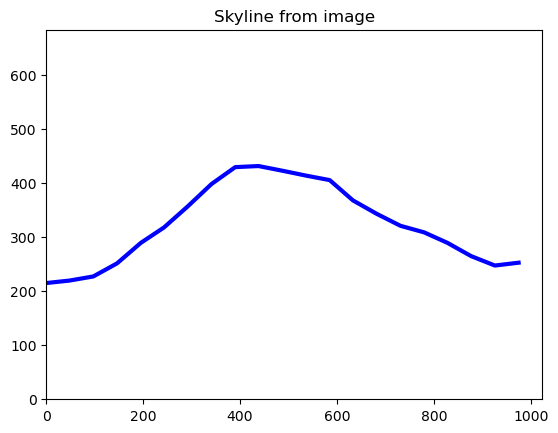

In [12]:
width, height = horizon_detector.img.size
image_skyline = load.load_skyline(img_path+'img_horizon.npy', fov, width, height, plot=True)

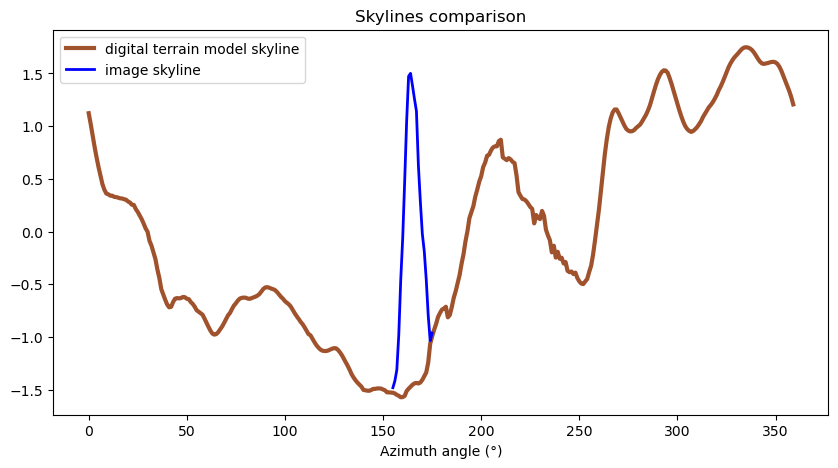

<Figure size 640x480 with 0 Axes>

In [15]:
fig = signal.plot_skylines_comparison(signal.normalize(smooth_skyline), signal.normalize(image_skyline), force_azimuth=azimuth)

In [17]:
# compute sliding square difference between reference signal (panoramic skyline) and shifted/noisy signal (skyline from image)
azimuth = signal.skylines_to_azimuth(smooth_skyline, image_skyline)
azimuth

25.5

In [ ]:
# example file of parameters
parameters = o3d.io.read_pinhole_camera_parameters("ScreenCamera_viewpoint.json")
# extrinsic matrix is computed for given azimuth and viewpoint
parameters.extrinsic = camera.get_extrinsic(azimuth, view_point)
#camera.visualize([pc], parameters)
key_to_callback = camera.callbacks(parameters, view_point)
o3d.visualization.draw_geometries_with_key_callbacks([pc], key_to_callback, width=width, height=height)

## Display estimation

In [ ]:
def pc_to_mesh(pc):
    pc.estimate_normals()
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pc, depth=9)
    vertices_to_remove = densities < np.quantile(densities, 0.05)
    mesh.remove_vertices_by_mask(vertices_to_remove)
    return mesh
mesh = pc_to_mesh(pc)
depths = camera.get_depths(mesh, parameters)

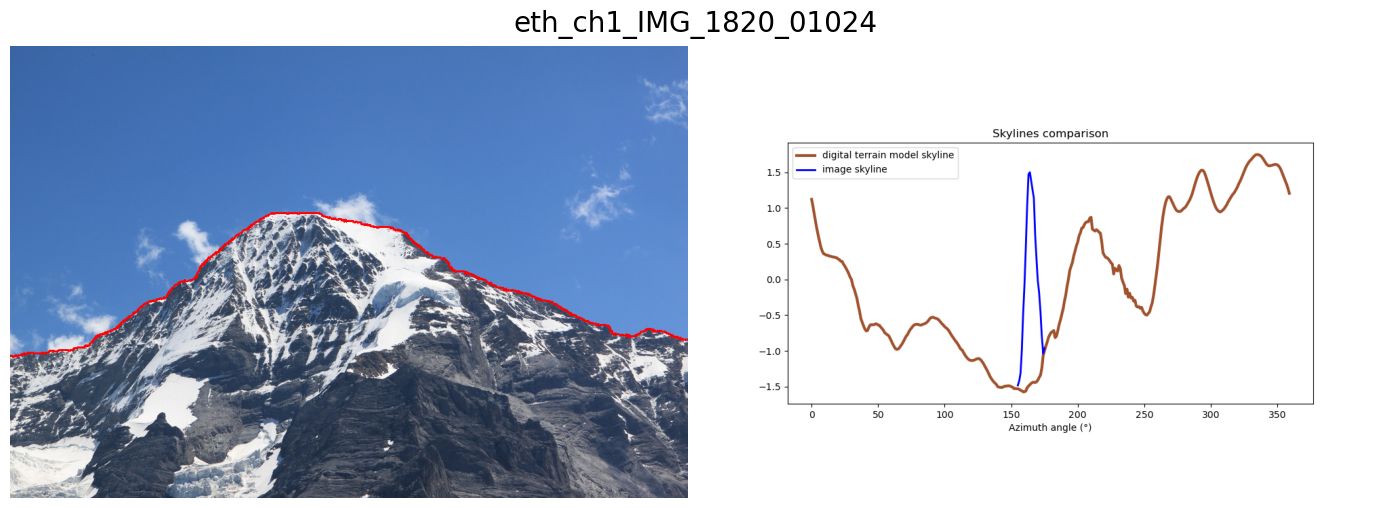

In [19]:
image.compare([horizon_detector.get_image_with_skyline(), fig], vpid) #image.depths_no_sky(depths)

In [246]:
# load trained adjustment model
modelpath='../data/models/trained_signal_adjustment.pth'
model = adjustment.AdjustmentModel(load_from=modelpath)

def predict_signal(ref_signal, sub_signal):
    '''Adjust a sub signal from a reference signal
    Args:
        ref_signal (np.array): reference signal
        sub_signal (np.array): sub signal
    Returns:
        np.array: adjusted signal
    '''
    # extract features
    features = adjustment.SignalLoader.get_features_from_pair(ref_signal, sub_signal)
    # predict adjustments
    prediction = model(features)
    # adjust
    adjusted_signal = adjustment.SignalLoader.adjust_signal(prediction, sub_signal)
    return adjusted_signal

## Repeat for different images

In [ ]:
n=5
horizon_detector = image.HorizonDetector()

for i, vp in viewpoints.iterrows():
    place_name = 'Alps_test'
    lat, lon, altitude = vp[['latitude', 'longitude', 'elevation']]
    view_point = project.to_xy(lat, lon, altitude, epsg='2056')
    # if not os.path.exists(terrain_data+place_name+'.xyz'):
    #     load.download_from_eio(terrain_data, place_name, lat, lon)
    #     pc = o3d.io.read_point_cloud(terrain_data+place_name+'.xyz')
    # else:
    #     pc = o3d.io.read_point_cloud(terrain_data+place_name+'.xyz')
    if os.path.exists(horizon_data+vp['id']+'.npy'):
        skyline = np.load(horizon_data+vp['id']+'.npy').astype(float)
    else:
        print('skipped '+vp['id'])
        continue
    # compute mesh if not yet defined for this place
    #if not mesh: 
    #    mesh = pc_to_mesh(pc)
    smooth_skyline = signal.smooth(skyline, n)
    # extract image horizon
    img_path = cam_data+vp['id']+'/'
    try:
        horizon_detector.load_image(img_path+'photo.jpg')
    except:
        print('no jpg found, trying jpeg')
        horizon_detector.load_image(img_path+'photo.jpeg')
    horizon_detector.estimate_depth()
    horizon_detector.extract_horizon()
    horizon_detector.save_horizon(img_path, 'img_horizon')
    fov = vp['fov']
    fov = round(math.degrees(fov))
    width, height = horizon_detector.img.size
    image_skyline = load.load_skyline(img_path+'img_horizon.npy', fov, width, height)
    # adjust image skyline
    # (no change for now, the model is not good for skylines from images)
    image_skyline_adjusted = image_skyline #predict_signal(smooth_skyline, image_skyline)
    # estimate azimuth
    #azimuth = signal.skylines_to_azimuth(smooth_skyline, image_skyline_adjusted)
    azimuth = vp['yaw']
    azimuth = round(math.degrees(azimuth))%360
    # example file of parameters
    #parameters = o3d.io.read_pinhole_camera_parameters("ScreenCamera_viewpoint.json")
    # extrinsic matrix is computed for given azimuth and viewpoint
    #parameters.extrinsic = camera.get_extrinsic(azimuth, view_point)
    # get depths
    #depths = camera.get_depths(mesh, parameters)
    image.compare([horizon_detector.get_image_with_skyline(), 
                   #image.depths_no_sky(depths), 
                   signal.plot_skylines_comparison(signal.normalize(smooth_skyline), signal.normalize(image_skyline_adjusted), force_azimuth=azimuth, plot=False)
                   ], vp['id'])
    